In [77]:
import pandas as pd

GIT = 'https://github.com/tyokokur/tmpdat/raw/main/nfh/'
dat = pd.read_csv(GIT+'NFH_train.txt', sep='\s+', names=['parent','chiname','b','v',
                                                         'cs','gH','tH0','tH1','tH2','tH3'])
chimax = [float(i.split('.')[2][2:]) / 100 for i in dat.chiname.values]
to_train = dat.iloc[:,2:].join(pd.Series(chimax, name='chimax'))
to_train = to_train[['b','v','chimax','cs','gH','tH0','tH1','tH2','tH3']]
display(to_train)

,b,v,chimax,cs,gH,tH0,tH1,tH2,tH3
0,2.2,1.20,3.10,0.004,37.76,89.82,84.25,77.82,69.56
1,2.2,1.20,3.10,0.005,27.73,80.27,74.45,67.77,59.27
2,2.2,1.20,3.10,0.006,22.46,71.73,65.75,58.97,50.65
3,2.2,1.20,3.10,0.008,18.72,62.46,56.79,50.55,43.16
4,2.2,1.20,3.10,0.010,16.57,57.21,51.86,45.95,38.91
...,...,...,...,...,...,...,...,...,...
585,2.5,1.25,3.15,0.015,14.60,52.64,46.77,40.23,32.48
586,2.5,1.25,3.15,0.020,12.81,46.76,40.83,34.17,26.35
587,2.5,1.25,3.15,0.030,11.55,39.16,33.16,26.67,19.67
588,2.5,1.25,3.15,0.040,11.03,34.76,29.04,23.13,17.11


In [117]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input  = torch.tensor(to_train.iloc[:,:4].values, dtype=torch.float32)
train_target = torch.tensor(to_train.tH0.values,  dtype=torch.float32).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, int(1e5), optimizer, loss_fn)

# Generate test input values
b_test = torch.linspace(0.5, 3.0, 50)
v_test = torch.linspace(0.1, 10, 50)
ch_test = torch.linspace(3.0, 4.0, 50)
cs_test = torch.logspace(-3, 2, 50)
B, V, CH, CS = torch.meshgrid(b_test, v_test, ch_test, cs_test)

# Compute curve predictions for test input values
test_input = torch.stack([B.flatten(), V.flatten(), CH.flatten(), CS.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(B.shape)

Epoch 0, loss 3802.975341796875
Epoch 1000, loss 24.99437713623047
Epoch 2000, loss 10.747851371765137
Epoch 3000, loss 4.335943698883057
Epoch 4000, loss 4.247453689575195
Epoch 5000, loss 2.8698692321777344
Epoch 6000, loss 3.2276761531829834
Epoch 7000, loss 2.2760443687438965
Epoch 8000, loss 2.250574827194214
Epoch 9000, loss 3.6433284282684326
Epoch 10000, loss 3.9059479236602783
Epoch 11000, loss 1.8341652154922485
Epoch 12000, loss 4.3819475173950195
Epoch 13000, loss 5.95786190032959
Epoch 14000, loss 3.1246466636657715
Epoch 15000, loss 1.873445749282837
Epoch 16000, loss 2.5465033054351807
Epoch 17000, loss 1.4876916408538818
Epoch 18000, loss 1.7278311252593994
Epoch 19000, loss 1.5979336500167847
Epoch 20000, loss 2.9942216873168945
Epoch 21000, loss 1.4202653169631958
Epoch 22000, loss 3.0126442909240723
Epoch 23000, loss 1.232275128364563
Epoch 24000, loss 1.4940959215164185
Epoch 25000, loss 3.0655484199523926
Epoch 26000, loss 1.0695078372955322
Epoch 27000, loss 1.592

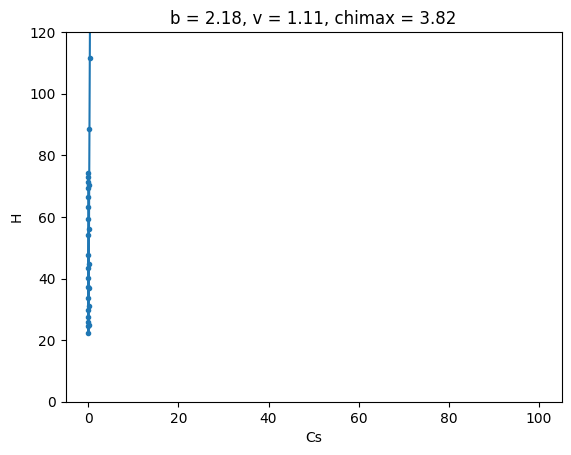

In [137]:
bind, vind, chind = 33, 5, 40
plt.subplots(1,1)
plt.plot(cs_test[:], curve_predictions[bind, vind, chind, :], '.-')
plt.title('b = {:.2f}, v = {:.2f}, chimax = {:.2f}'.format(b_test[bind].numpy(), v_test[vind].numpy(), ch_test[chind].numpy()))
plt.xlabel('Cs')
plt.ylabel('H')
plt.ylim(0, 120)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Globals ##
n_in  = 2
n_out = 1


# Define the target function
def target_function(x, y):
    return x**2 - y**3


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    global n_in
    global n_out 
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_in, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input = torch.empty(1000, n_in).uniform_(0, 1)
train_target = target_function(train_input[:, 0], train_input[:, 1]).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_test, y_test)

# Compute curve predictions for test input values
test_input = torch.stack([X.flatten(), Y.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(X.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(X, Y, target_function(X, Y), levels=20, cmap='viridis')
ax.set_title('True Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the predicted curve
ax = fig.add_subplot(122)
ax.contourf(X, Y, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Show the plot
plt.show()

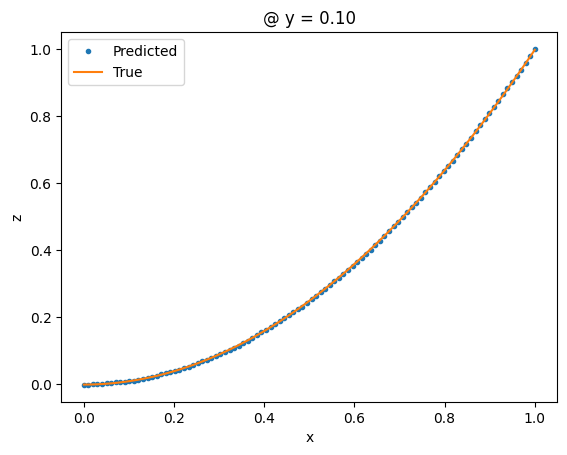

In [2]:
f, ax = plt.subplots(1,1)
yind = 10
ax.plot(X[:,yind], curve_predictions[:,yind], 'o', ms=3, label='Predicted')
ax.plot(X[:,yind], target_function(X[:,yind], Y[:,yind]), label='True')
ax.set_title('@ y = {:.2f}'.format(Y[0, yind].numpy()))
ax.set_ylabel('z')
ax.set_xlabel('x')

plt.legend()
plt.show()

In [139]:
to_train.tH0.values

array([ 89.82,  80.27,  71.73,  62.46,  57.21,  49.81,  44.78,  37.32,
        32.71,  29.95,  90.49,  85.11,  75.69,  64.86,  58.85,  50.94,
        45.95,  38.58,  33.83,  30.9 ,  88.59,  76.2 ,  69.49,  61.27,
        56.48,  49.41,  44.42,  37.01,  32.49,  29.8 ,  87.49,  75.26,
        68.86,  60.93,  56.28,  49.28,  44.3 ,  36.92,  32.42,  29.76,
        90.52,  85.99,  81.4 ,  68.94,  60.98,  51.18,  45.38,  37.87,
        33.64,  31.15,  89.62,  84.13,  75.06,  63.16,  57.  ,  48.39,
        42.63,  35.39,  31.59,  29.42,  90.11,  85.27,  79.24,  65.9 ,
        58.86,  49.77,  44.01,  36.61,  32.58,  30.26,  89.39,  83.38,
        73.31,  62.18,  56.31,  47.84,  42.07,  34.91,  31.2 ,  29.1 ,
        88.99,  81.25,  70.91,  60.8 ,  55.34,  47.01,  41.24,  34.21,
        30.65,  28.64,  88.67,  78.84,  69.44,  59.96,  54.72,  46.45,
        40.69,  33.76,  30.29,  28.35,  88.77,  78.82,  69.09,  59.6 ,
        54.39,  46.07,  40.29,  33.42,  30.03,  28.13,  92.88,  88.84,
      